In [1]:
%load_ext autoreload
%autoreload 2

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # For Google Colab
    !git clone https://github.com/rainorangelemon/complift-2d-and-clevr.git
    %cd 2d-and-clevr
else:
    # For local notebook
    %cd ..

/home/rainorangelemon/Documents


/home/rainorangelemon/micromamba/envs/sam2/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Train Component Distributions

We train one model for each distribution.
There are 3 algebras x 3 environments x 2 component = 18 models to train. Here we only train the 2 models for the 1st environment of product.

In [4]:
!wandb login

wandb: Currently logged in as: rainorangelemon. Use `wandb login --relogin` to force relogin


The following script takes roughly 12 minutes to run for training product_a1 and product_a2 on RTX 4090.

In [7]:
%%bash
#!/bin/bash

experiments=('product') # 'summation' 'negation'
suffixes=('a1' 'a2') # 'b1' 'b2' 'c1' 'c2'

for exp in "${experiments[@]}"
do
    for suffix in "${suffixes[@]}"
    do
        experiment_name="${exp}_${suffix}"
        # if there is error, remove the "> /dev/null 2>&1" and run it in terminal to debug
        python ddpm.py --experiment_name "$experiment_name" --dataset "$experiment_name" --num_epochs 1000 --mlp_type energy > /dev/null 2>&1
    done
done

## Inference - Load Trained Model

In [12]:
import torch
import ddpm
import baselines_2d
from utils_2d import plot_points
import matplotlib.pyplot as plt

algebra = "product"
suffix = "a"
device = ddpm.device

model_1 = ddpm.EnergyMLP().to(device)
model_2 = ddpm.EnergyMLP().to(device)
model_1.load_state_dict(torch.load(f"exps/{algebra}_{suffix}1/ema_model.pth", weights_only=True))
model_2.load_state_dict(torch.load(f"exps/{algebra}_{suffix}2/ema_model.pth", weights_only=True))
model_to_test = ddpm.CachedCompositionEnergyMLP(model_1, model_2, algebra=algebra)
scheduler = ddpm.NoiseScheduler(num_timesteps=50)

## Inference - Composable Diffusion

  0%|          | 0/50 [00:00<?, ?it/s]

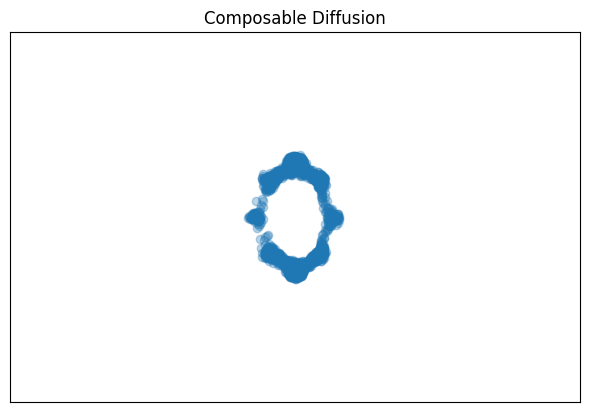

In [13]:
generated_samples_diffusion = baselines_2d.diffusion_baseline(model_to_test, diffusion=scheduler)[-1] # get the samples at the final timestep
plot_points(generated_samples_diffusion)
plt.title("Composable Diffusion")
plt.show()

## Inference - CompLift

  0%|          | 0/50 [00:00<?, ?it/s]

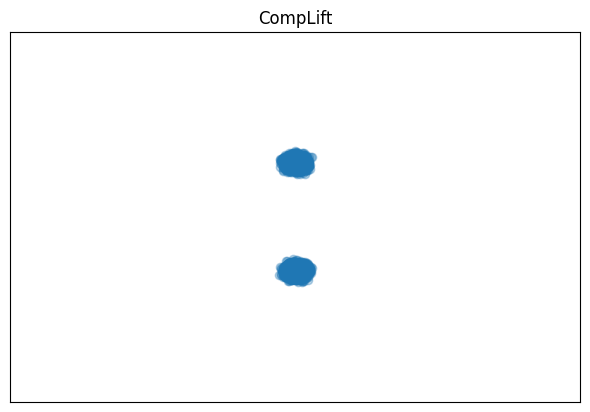

In [17]:
elbo_cfg = {
  "alpha": 0.9,
  "n_samples": 50,
  "same_noise": False,  # if true, sample the same epsilon for all (t, epsilon) pairs
  "sample_timesteps": "random",  # choose among {interleave, random, specified{timesteps}}
  "mini_batch": 200000,
}
generated_samples_rejection, _, acceptance_ratio, _ = baselines_2d.rejection_baseline(
                                                              composed_denoise_fn=model_to_test,
                                                              conditions_denoise_fn=[model_1, model_2],
                                                              # the first algebra needs to be product, see implementation of rejection_baseline
                                                              algebras=["product", algebra],
                                                              x_shape=(2,),
                                                              noise_scheduler=scheduler,
                                                              num_samples_to_generate=8000,
                                                              elbo_cfg=elbo_cfg,
                                                              progress=True)
generated_samples_rejection = generated_samples_rejection[-1]
plot_points(generated_samples_ebm);
plt.title("CompLift")
plt.show()

## Inference - Cached CompLift

  0%|          | 0/50 [00:00<?, ?it/s]

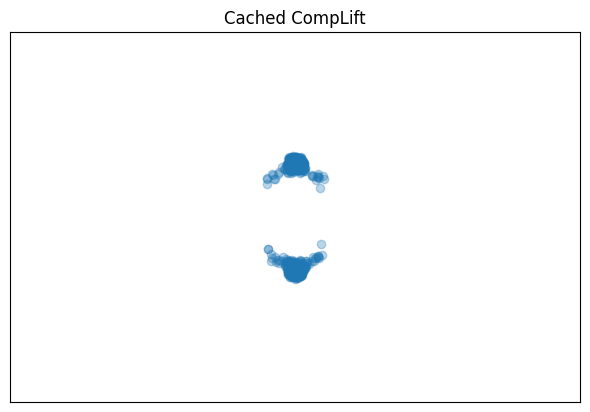

In [18]:
generated_samples_cached_rejection, acceptance_ratio_cached = baselines_2d.cache_rejection_baseline(
                                                               composed_denoise_fn=model_to_test,
                                                               algebras=["product", algebra],
                                                               x_shape=(2,),
                                                               noise_scheduler=scheduler,
                                                               num_samples_to_generate=8000,
                                                               elbo_cfg=elbo_cfg,
                                                               progress=True)
plot_points(generated_samples_cached_rejection);
plt.title("Cached CompLift")
plt.show()

## Inference - EBM

  0%|          | 0/50 [00:00<?, ?it/s]

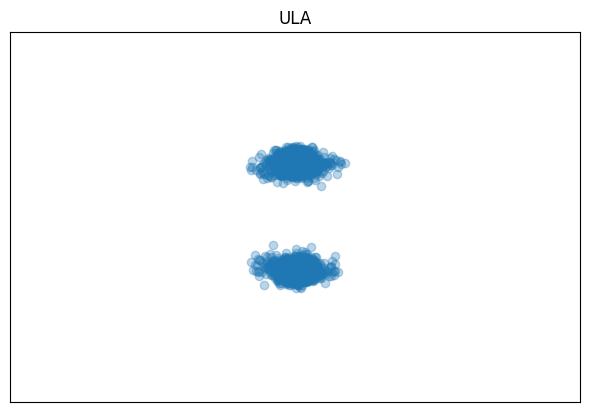

  0%|          | 0/50 [00:00<?, ?it/s]

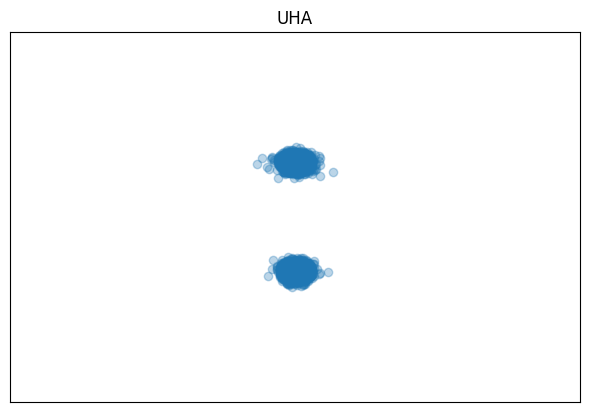

  0%|          | 0/50 [00:00<?, ?it/s]

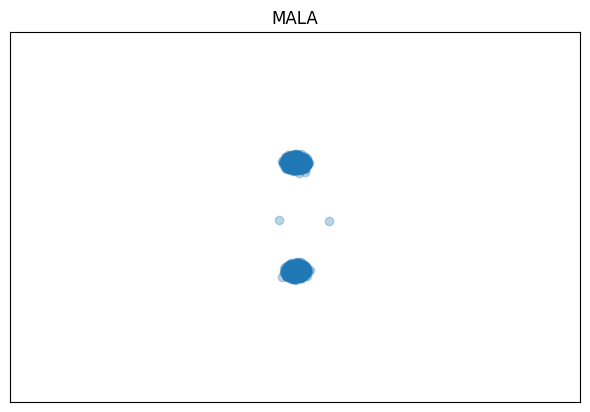

  0%|          | 0/50 [00:00<?, ?it/s]

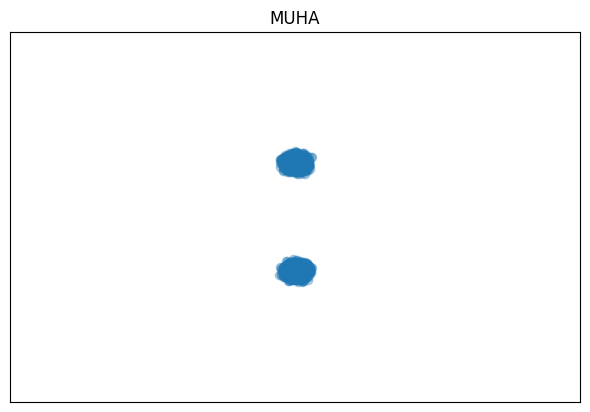

In [8]:
for sampler_type in ["ULA", "UHA", "MALA", "MUHA"]:
    generated_samples_ebm = baselines_2d.ebm_baseline(composed_denoise_fn=model_to_test,
                                                      composed_energy_fn=lambda x, t: model_to_test.energy(x, t),
                                                      x_shape=(2,),
                                                      noise_scheduler=scheduler,
                                                      num_samples_to_generate=8000,
                                                      sampler_type=sampler_type)
    plot_points(generated_samples_ebm);
    plt.title(sampler_type)
    plt.show()

Congrats for completing the quickstart! For a more thorough comparison, feel free to check `2d-and-clevr/scripts/run_baselines_2d.py`